In [1]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy
import pandas
from keras.layers import Dense, LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


# Function for Loading Dataset
This function use Pandas for loading csv dataset. MinMaxScaler uses for normalizaing dataset.

In [2]:
def load_dataset(datasource):
    """
    The function loads dataset from given file name and uses MinMaxScaler to transform data
    :param datasource: file name of data source
    :return: tuple of dataset and the used MinMaxScaler
    """
    # load the dataset
    dataframe = pandas.read_csv(datasource, usecols=[1])
    dataframe = dataframe.fillna(method='pad')
    dataset = dataframe.values
    dataset = dataset.astype('float32')

    plt.plot(dataset)
    plt.show()

    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    return dataset, scaler

# Function for Creating Dataset
This function create training inputs and outputs with look_back parameter.

In [3]:
def create_dataset(dataset, look_back=1):
    """
    The function takes two arguments: the `dataset`, which is a NumPy array that we want to convert into a dataset,
    and the `look_back`, which is the number of previous time steps to use as input variables
    to predict the next time period — in this case defaulted to 1.
    :param dataset: numpy dataset
    :param look_back: number of previous time steps as int
    :return: tuple of input and output dataset
    """
    data_x, data_y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        data_x.append(a)
        data_y.append(dataset[i + look_back, 0])
    return numpy.array(data_x), numpy.array(data_y)

# Function for Spliting Dataset
This function split dataset to train and test.

In [4]:
def split_dataset(dataset, train_size, look_back):
    """
    Splits dataset into training and test datasets. The last `look_back` rows in train dataset
    will be used as `look_back` for the test dataset.
    :param dataset: source dataset
    :param train_size: specifies the train data size
    :param look_back: number of previous time steps as int
    :return: tuple of training data and test dataset
    """
    if not train_size > look_back:
        raise ValueError('train_size must be lager than look_back')
    train, test = dataset[0:train_size, :], dataset[train_size - look_back:len(dataset), :]
    print('train_dataset: {}, test_dataset: {}'.format(len(train), len(test)))
    return train, test

# Model Area

In [5]:
def build_model(look_back, batch_size=1):
    """
    The function builds a keras Sequential model
    :param look_back: number of previous time steps as int
    :param batch_size: batch_size as int, defaults to 1
    :return: keras Sequential model
    """
    model = Sequential()
    model.add(LSTM(64,
                   activation='relu',
                   batch_input_shape=(batch_size, look_back, 1),
                   stateful=True,
                   return_sequences=False))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Plot Dataset and Model Predictions

In [7]:
def plot_data(dataset,
              look_back,
              train_predict,
              test_predict,
              forecast_predict):
    """
    Plots baseline and predictions.

    blue: baseline
    green: prediction with training data
    red: prediction with test data
    cyan: prediction based on predictions

    :param dataset: dataset used for predictions
    :param look_back: number of previous time steps as int
    :param train_predict: predicted values based on training data
    :param test_predict: predicted values based on test data
    :param forecast_predict: predicted values based on previous predictions
    :return: None
    """
    plt.plot(dataset)
    plt.plot([None for _ in range(look_back)] +
             [x for x in train_predict])
    plt.plot([None for _ in range(look_back)] +
             [None for _ in train_predict] +
             [x for x in test_predict])
    plt.plot([None for _ in range(look_back)] +
             [None for _ in train_predict] +
             [None for _ in test_predict] +
             [x for x in forecast_predict])
    plt.show()

# Function for forecasting

In [8]:
def make_forecast(model, look_back_buffer, timesteps=1, batch_size=1):
    forecast_predict = numpy.empty((0, 1), dtype=numpy.float32)
    for _ in range(timesteps):
        # make prediction with current lookback buffer
        cur_predict = model.predict(look_back_buffer, batch_size)
        # add prediction to result
        forecast_predict = numpy.concatenate([forecast_predict, cur_predict], axis=0)
        # add new axis to prediction to make it suitable as input
        cur_predict = numpy.reshape(cur_predict, (cur_predict.shape[1], cur_predict.shape[0], 1))
        # remove oldest prediction from buffer
        look_back_buffer = numpy.delete(look_back_buffer, 0, axis=1)
        # concat buffer with newest prediction
        look_back_buffer = numpy.concatenate([look_back_buffer, cur_predict], axis=1)
    return forecast_predict

# Load Dataset

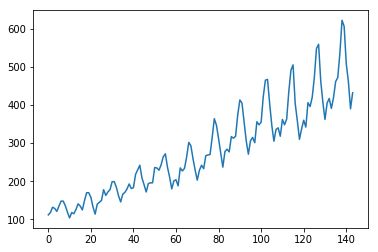

In [9]:
datasource = 'international-airline-passengers.csv'
dataset, scaler = load_dataset(datasource)

# Split Dataset

In [11]:
# split into train and test sets
look_back = int(len(dataset) * 0.20)
train_size = int(len(dataset) * 0.70)
train, test = split_dataset(dataset, train_size, look_back)

train_dataset: 100, test_dataset: 72


# Prepare Train and Test Data

In [12]:
# reshape into X=t and Y=t+1
train_x, train_y = create_dataset(train, look_back)
test_x, test_y = create_dataset(test, look_back)

# Reshape Data

In [13]:
# reshape input to be [samples, time steps, features]
train_x = numpy.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
test_x = numpy.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))

# Model Creation

In [14]:
# create and fit model
batch_size = 1
model = build_model(look_back, batch_size=batch_size)

# Train Loop

In [15]:
print('Train Started!!!')
for i in range(100):
    model.fit(train_x, train_y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()
print('Train Finished!!!')

Train Started!!!
Epoch 1/1
71/71 [==============================] - 3s 48ms/step - loss: 0.0105
Epoch 1/1
71/71 [==============================] - 3s 37ms/step - loss: 0.0069
Epoch 1/1
71/71 [==============================] - 3s 37ms/step - loss: 0.0078
Epoch 1/1
71/71 [==============================] - 3s 37ms/step - loss: 0.0082
Epoch 1/1
71/71 [==============================] - 3s 37ms/step - loss: 0.0081
Epoch 1/1
71/71 [==============================] - 3s 36ms/step - loss: 0.0079
Epoch 1/1
71/71 [==============================] - 3s 37ms/step - loss: 0.0075
Epoch 1/1
71/71 [==============================] - 3s 37ms/step - loss: 0.0071
Epoch 1/1
71/71 [==============================] - 3s 37ms/step - loss: 0.0068
Epoch 1/1
71/71 [==============================] - 3s 37ms/step - loss: 0.0064
Epoch 1/1
71/71 [==============================] - 3s 38ms/step - loss: 0.0061
Epoch 1/1
71/71 [==============================] - 3s 38ms/step - loss: 0.0059
Epoch 1/1
71/71 [==================

# Using Model

In [16]:
# generate predictions for training
train_predict = model.predict(train_x, batch_size)
test_predict = model.predict(test_x, batch_size)

# generate forecast predictions
forecast_predict = make_forecast(model, test_x[-1::], timesteps=100, batch_size=batch_size)

# invert dataset and predictions
dataset_inverse = scaler.inverse_transform(dataset)
train_predict_inverse = scaler.inverse_transform(train_predict)
train_y_inverse = scaler.inverse_transform([train_y])
test_predict_inverse = scaler.inverse_transform(test_predict)
test_y_inverse = scaler.inverse_transform([test_y])
forecast_predict_inverse = scaler.inverse_transform(forecast_predict)

# calculate root mean squared error
train_score = numpy.sqrt(mean_squared_error(train_y_inverse[0], train_predict_inverse[:, 0]))
print('Train Score: %.2f RMSE' % train_score)
test_score = numpy.sqrt(mean_squared_error(test_y_inverse[0], test_predict_inverse[:, 0]))
print('Test Score: %.2f RMSE' % test_score)

plot_data(dataset_inverse, look_back, train_predict_inverse, test_predict_inverse, forecast_predict_inverse)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').